In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from model_trainer import LabelTransferTrainer
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-07-21 15:54:19.303207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 15:54:19.888515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:/usr/local/cuda-12.1/lib64:/usr/local/cuda-12.1/lib64:/usr/local/cuda-12.1/lib64
2023-07-21 15:54:19.888562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/l

In [2]:
datasets = pd.read_csv('datasets.csv')
datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

In [3]:
trainer = LabelTransferTrainer(hyperparams_file='hyperparams.csv',
                               data_dir='exported_matrices',
                               output_dir='label_transfer_model_output',
                               verbose=False,
                               random_seed=12345)

trainer.save_models_plots()

# Hyperparameter tuning

In [4]:
study_id = 'Lopez2021M'

do_hyperparam_search = False

In [5]:
if do_hyperparam_search:
    param = "bn_momentum"
    values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    res = trainer.tune_hyperparam(study_id, param, values, n_folds=10)

    res_df = pd.DataFrame({"F1": res.values(), 
                        "Nodes": [k.split("_")[0] for k in res.keys()], 
                        "Fold": [k.split("_")[1] for k in res.keys()]})

    # Get the mean of the folds
    means = res_df.groupby(['Nodes']).mean(numeric_only=True)
    sd = res_df.groupby(['Nodes']).std(numeric_only=True)
    min_f1 = res_df.groupby(['Nodes']).min()['F1']
    max_f1 = res_df.groupby(['Nodes']).max()['F1']

    plt.plot(values, means['F1'], color='gray')
    plt.scatter(values, means['F1'], 
                c=["red" if m == max(means['F1']) else "black" for m in means["F1"]],
                s = [30 if m == max(means['F1']) else 10 for m in means["F1"]])
    plt.fill_between(values, means['F1'] - sd['F1'], means['F1'] + sd['F1'],
                    alpha=0.3, color='grey')
    plt.fill_between(values, min_f1, max_f1, alpha=0.1,
                    color='grey')
    plt.text(0, 0.9, f"Best F1 at {values[np.argmax(means['F1'])]}")
    plt.title(f"Tuning of {param} on {study_id}")
    plt.xlabel('Units')
    plt.ylabel('F1 Score')
    plt.ylim([0, 1])
    plt.show()

In [6]:
if do_hyperparam_search:
    tf.keras.backend.clear_session()
    trainer.models[study_id], history = trainer.train_single_model(study_id)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].plot(history['loss'], label='train')
    ax[0].plot(history['val_loss'], label='validation')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(history['f1_score'], label='train')
    ax[1].plot(history['val_f1_score'], label='validation')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 score')

    plt.tight_layout()

# Training

In [22]:
trainer.train_all_models(reset_models=False)

Training model Allensworth2021F for 300 epochs...
Training model Cheung2018M for 200 epochs...
Training model Fletcher2019F for 200 epochs...
Training model Fletcher2019M for 200 epochs...
Training model Kucka2021F for 200 epochs...
Training model Lopez2021M for 200 epochs...
Training model Mayran2019M for 200 epochs...
Training model Ruf_Zamojski2021F for 200 epochs...
Training model Ruf_Zamojski2021M for 200 epochs...
Training model Vennekens2021M for 400 epochs...


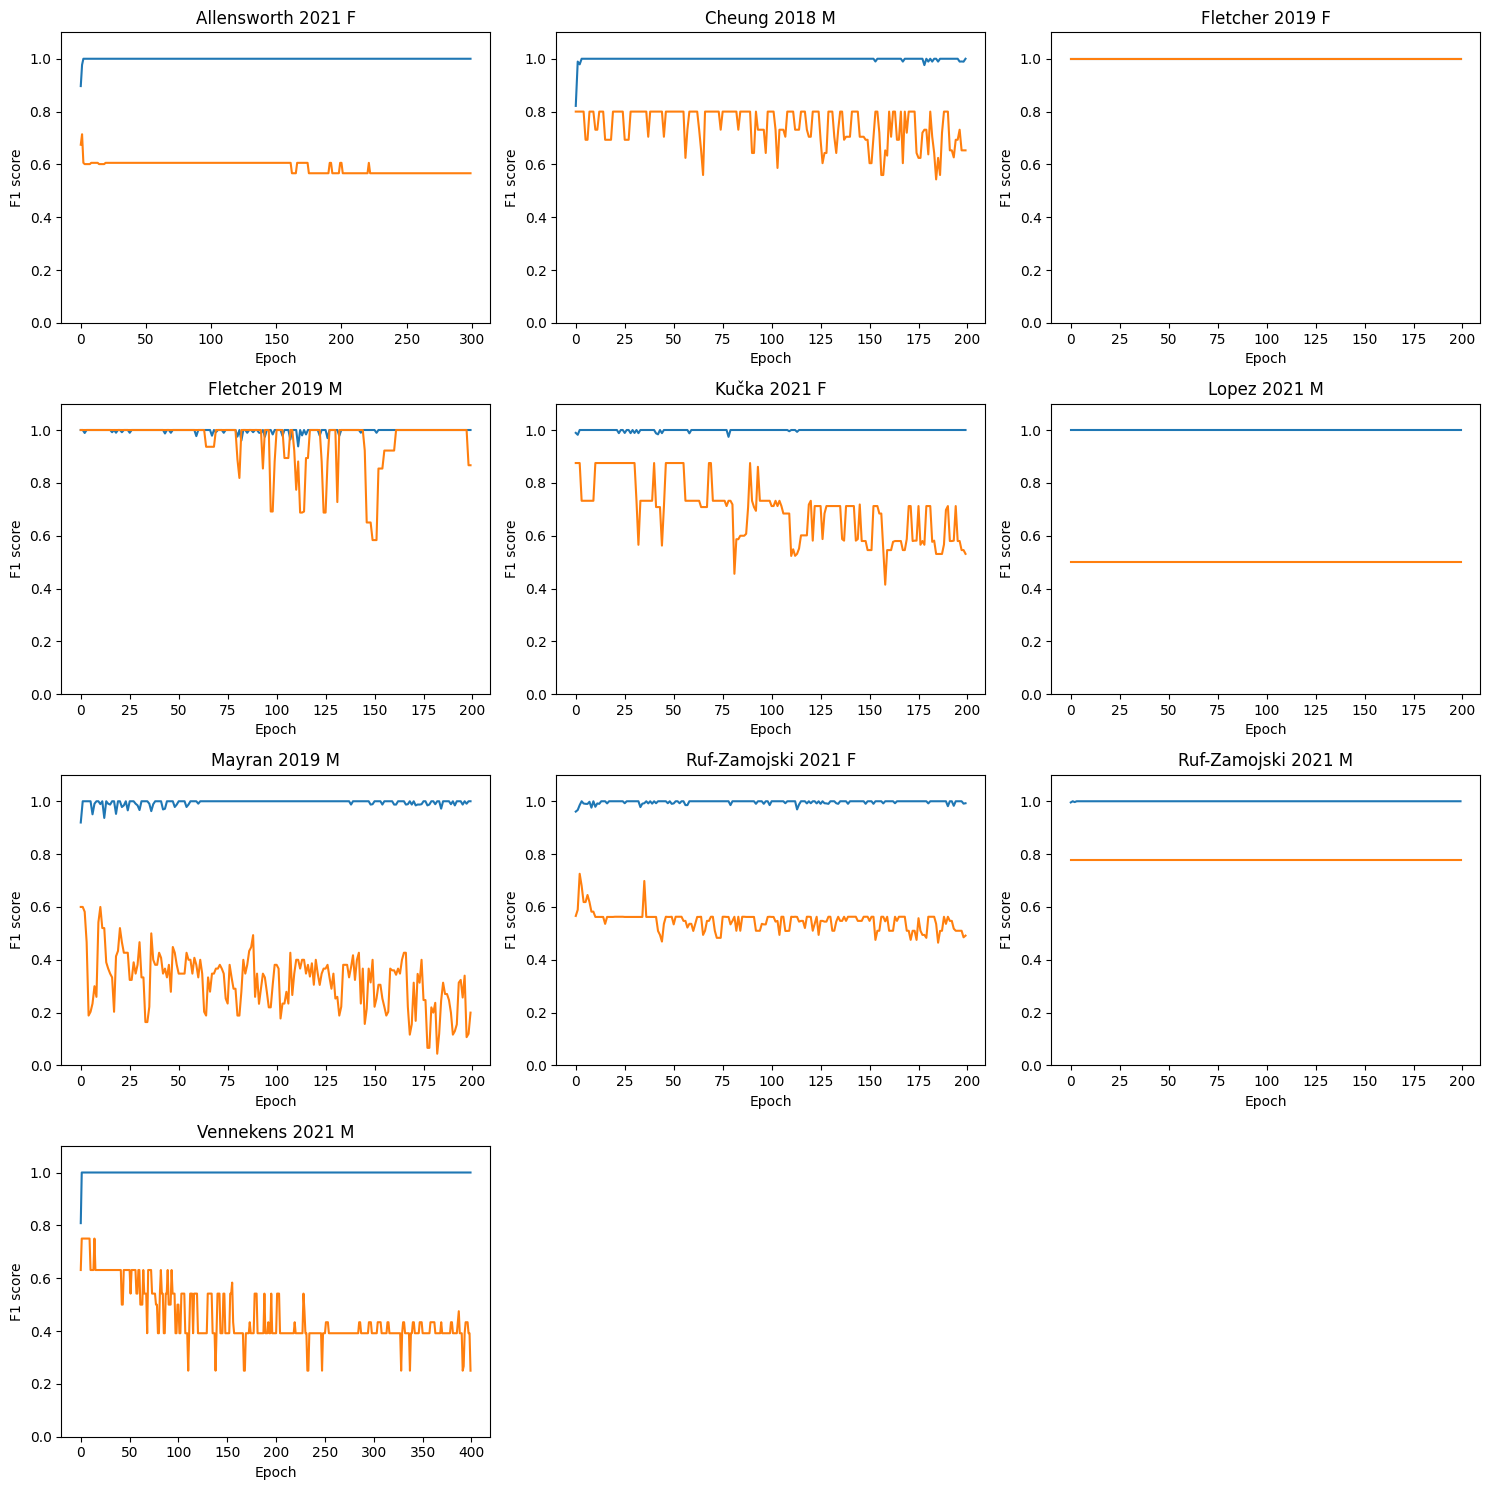

In [23]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))

dataset_names = [
    f"{d['author']} {d['year']} {d['sex']}" for _, d in datasets.iterrows()]
dataset_names = np.unique(dataset_names)
hist_keys = list(trainer.training_histories.keys())

for i, d in enumerate(dataset_names):
    a = ax.ravel()[i]
    a.plot(trainer.training_histories[hist_keys[i]]['f1_score'])
    a.plot(trainer.training_histories[hist_keys[i]]['val_f1_score'])
    a.set_title(d)
    a.set_ylim([0, 1.1])
    a.set_xlabel('Epoch')
    a.set_ylabel('F1 score')

ax.ravel()[-1].axis('off')
ax.ravel()[-2].axis('off')
plt.tight_layout()

4/4 [==============================] - 0s 3ms/step - loss: 22.1126 - f1_score: 0.8699


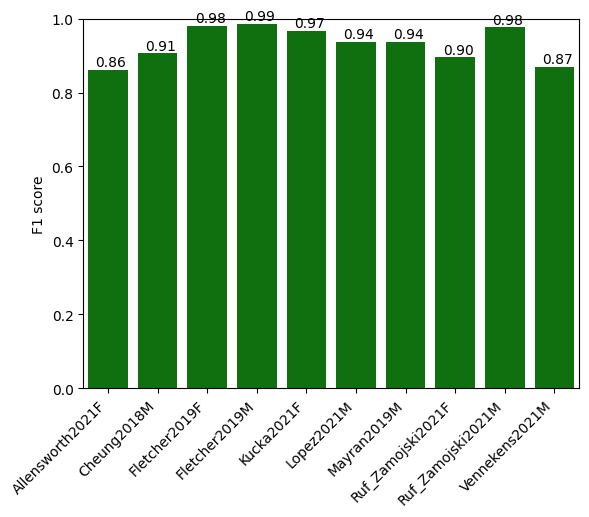

0.86,0.91,0.98,0.99,0.97,0.94,0.94,0.90,0.98,0.87,

In [24]:
eval_res = trainer.evaluate_models()

f1 = [r[1] for r in eval_res.values()]
# barplot of the F1 scores, colored in red if the F1 score is below 0.5, yellow if below 0.8,
# and green otherwise
sns.barplot(x=list(eval_res.keys()), y=f1,
            palette=['red' if f < 0.5 else 'yellow' if f < 0.8 else 'green' for f in f1])


for i, v in enumerate(f1):
    plt.text(i - 0.25, v + 0.01, f"{v:.2f}")
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.ylabel('F1 score')
plt.show()

for f in f1:
    print(f"{f:.2f},", end="")

In [15]:
# Check predictions of each model on the UMAP of the dataset it was trained on
umap, clusters, expr, predictions = {}, {}, {}, {}

for d in datasets['study_id'].unique():
    print(f"Processing {d}")
    umap[d] = pd.read_csv(f"exported_matrices/{d}_umap.csv", index_col=0)
    expr[d] = pd.read_csv(f"exported_matrices/{d}_expression.csv", index_col=0).transpose()
    clusters[d] = pd.read_csv(f"exported_matrices/{d}_clusters.csv", index_col=0)
    predictions[d] = trainer.models[d].predict(expr[d])
    predictions[d] = [np.argmax(p) if np.max(p) > 0.5 else -1 for p in predictions[d]]

Processing Ruf_Zamojski2021F
80/80 [==============================] - 0s 930us/step
Processing Ruf_Zamojski2021M
85/85 [==============================] - 0s 931us/step
Processing Lopez2021M
12/12 [==============================] - 0s 908us/step
Processing Allensworth2021F
41/41 [==============================] - 0s 890us/step
Processing Vennekens2021M
17/17 [==============================] - 0s 870us/step
Processing Mayran2019M
30/30 [==============================] - 0s 950us/step
Processing Cheung2018M
31/31 [==============================] - 0s 940us/step
Processing Kucka2021F
77/77 [==============================] - 0s 1ms/step
Processing Fletcher2019F
25/25 [==============================] - 0s 924us/step
Processing Fletcher2019M
35/35 [==============================] - 0s 962us/step


In [16]:
for p in predictions:
    # Are there -1 predictions?
    if -1 in predictions[p]:
        print(f"{p} has {np.sum(np.array(predictions[p]) == -1)} -1 predictions")

Ruf_Zamojski2021F has 89 -1 predictions
Lopez2021M has 20 -1 predictions
Allensworth2021F has 106 -1 predictions
Vennekens2021M has 145 -1 predictions
Mayran2019M has 16 -1 predictions
Cheung2018M has 36 -1 predictions
Kucka2021F has 34 -1 predictions


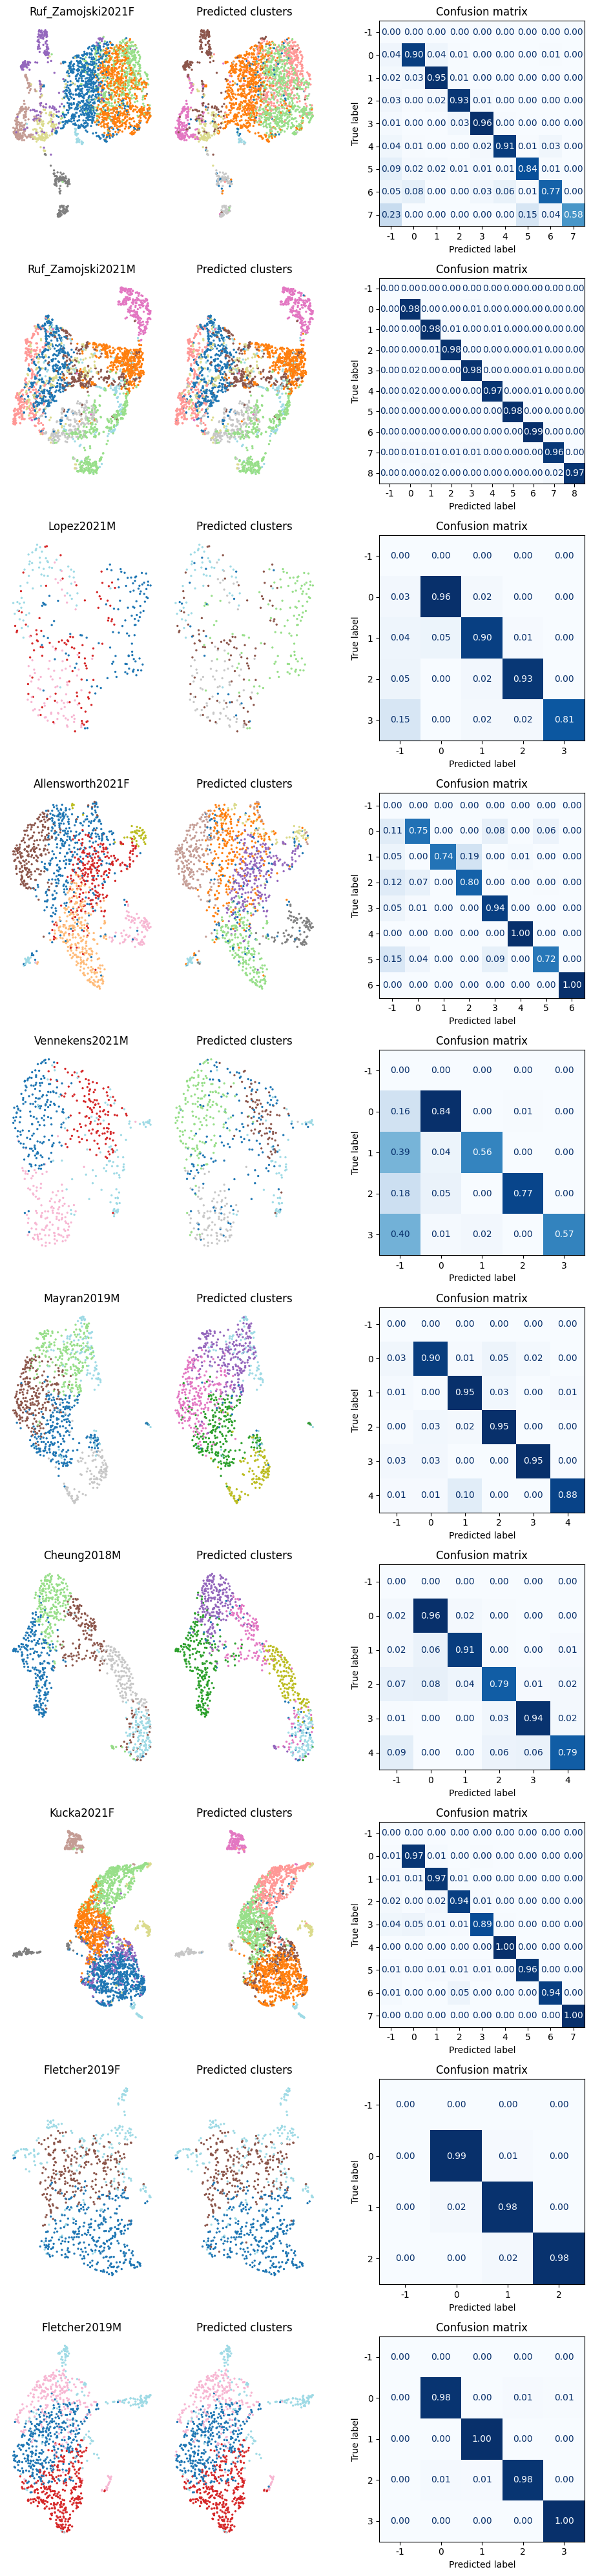

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_, ax = plt.subplots(len(umap), 3, figsize=(10, 4 * len(umap)), width_ratios=[1, 1, 2])

for i in range(len(umap)):
    dataset = list(umap.keys())[i]
    ax[i, 0].scatter(umap[dataset]['UMAP_1'], umap[dataset]['UMAP_2'], c = clusters[dataset]['Cluster'], s=2, cmap='tab20')
    ax[i, 0].set_title(dataset)
    ax[i, 0].axis('off')    
    
    ax[i, 1].scatter(umap[dataset]['UMAP_1'], umap[dataset]['UMAP_2'], c = predictions[dataset], s=2, cmap='tab20')
    ax[i, 1].set_title("Predicted clusters")
    ax[i, 1].axis('off')
    
    cm = confusion_matrix(clusters[dataset]['Cluster'], predictions[dataset], normalize='true')
    
    if cm.shape[0] == clusters[dataset]['Cluster'].nunique(): # We don't have any -1 predictions
        # Add a column and row of zeros
        cm = np.pad(cm, ((1, 0), (1, 0)), 'constant', constant_values=0)    
    
    ConfusionMatrixDisplay(cm).plot(ax=ax[i, 2], cmap='Blues', colorbar=False, values_format='.2f')
    ax[i, 2].set_title("Confusion matrix")
    ax[i, 2].set_xticklabels(range(-1, cm.shape[0]-1))
    ax[i, 2].set_yticklabels(range(-1, cm.shape[0]-1))
    
plt.tight_layout()